---
title: Auditing Allocative Bias
author: Anweshan Adhikari
date: '2023-04-11'
image: "image.jpg"
description: "Exploring the impact of algorithmic decision making on equality"
format: html
---

# Introduction to the dataset

In this blog, we will be working with data from American Community Survey using the ACSDataSource class. Each row in our datset represents an individual who took the PUMA survey in Colorado, USA. First, let's have a look at our dataset:.

In [1]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "CO"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000225,8,1,300,4,8,1013097,26,16,...,23,4,24,33,53,46,5,4,47,42
1,P,2018GQ0000483,8,1,4103,4,8,1013097,41,19,...,7,40,39,43,41,6,41,6,41,44
2,P,2018GQ0000529,8,1,4101,4,8,1013097,16,24,...,31,16,1,32,17,15,16,17,2,18
3,P,2018GQ0000670,8,1,818,4,8,1013097,3,22,...,6,3,2,7,3,4,5,3,3,3
4,P,2018GQ0000721,8,1,819,4,8,1013097,17,65,...,22,0,17,37,0,0,30,16,17,1


It is evident that our dataset consists of a lot of columns, each representing a different feature of interest. Some of such features are race(RAC1P), sex(SEX), employment status(ESR), Marital status(MAR) and so on. However, for the purposes of this blog, we will only be using some of these features. The features I have chosen are age, race, disability record, nativity  ,income and citizenship status because these factors are usually associated with allocative bias in different social contexts.


In [2]:
#subsetting the features
# Reducing number of features
possible_features=["PINCP", "RAC1P", "CIT","SEX", "DIS","AGEP","NATIVITY"]
acs_data[possible_features]
features_to_use = [f for f in possible_features if f not in ["PINCP","SEX"]]

From the folktables library, we will be usig the BasicProblem class to make a problem to predict whether a not an individual's income is greater that $50k based on their Race.

In [3]:
IncomeProblem = BasicProblem(
    features=features_to_use,
    target='PINCP', #total person's income
    target_transform=lambda x: 1*(x>50000),
    group=['SEX'],
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = IncomeProblem.df_to_numpy(acs_data)

Once we create the IncomeProblem object, we convert the dataframe to a numpy array that will feature three variables: features, label and group. We can then use these arrays to train our models. We will then be splitting out data set into training data and testing data. We can do so by using the train-test split class from the sklearn.model_selection model library. A test_size of 0.2 means that 20% of out dataset will be used for the testing dataset and 80% will be used as the training data set. After train-test split we will be ready to create a model and use our training data to train it.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Basic Descriptives

In [5]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train
df.shape

(44742, 7)

The shape that the training dataset consists of 214,480 observations, with each instance having values for 7 different features.

Let' see how many of these observations have an income of <= to an income of $50,000. As shown in the output below, 79.39% of people in Colorado have an income of less that or equal to 50,000 dollars.

In [6]:
income_gt_50k = df[df["label"] == 1].shape[0]
income_lt_50k = df[df["label"] == 0].shape[0]

total_count = df.shape[0]
income_gt_50k_percent = income_gt_50k / total_count * 100
income_lt_50k_percent = income_lt_50k / total_count * 100

results = pd.DataFrame({
    "Income": ["<= $50,000", "> $50,000"],
    "Count": [income_lt_50k, income_gt_50k],
    "Percentage": [income_lt_50k_percent, income_gt_50k_percent]
})

print(results)

       Income  Count  Percentage
0  <= $50,000  32972   73.693621
1   > $50,000  11770   26.306379


If we were to delve deeper, we can seethat out of the people who have an income higher than $50,000 dollars, 26.87% are male while 14.56% are females.

In [7]:
income_gt_50k = df[df["label"] == 1]
male_income_gt_50k = income_gt_50k[income_gt_50k["group"] == 1]
female_income_gt_50k = income_gt_50k[income_gt_50k["group"] == 2]

male_percent = len(male_income_gt_50k) / len(df[df["group"] == 1]) * 100
female_percent = len(female_income_gt_50k) / len(df[df["group"] == 2]) * 100

results = pd.DataFrame({
    "Group": ["Male", "Female"],
    "Percentage": [male_percent, female_percent]
})

print(results.to_string(index=False))



 Group  Percentage
  Male   32.725562
Female   19.915254


The results produced from the code below shows the percentage of males that have an income of greater than $50,000 and percentage of female with an income greater than $50,000.

In [8]:
income_gt_50k = df[df["label"] == 1]
income_count = income_gt_50k.groupby("group").size()
total_count = income_gt_50k.shape[0]
income_percent = income_count / total_count * 100

results = pd.DataFrame({
    "Group": ["Male", "Female"],
    "Count": list(income_count),
    "Percentage": list(income_percent)
})

print(results.to_string(index=False))


 Group  Count  Percentage
  Male   7305   62.064571
Female   4465   37.935429


We can observe that 64% of the total male have an income greater than $50k while 36% of the total female population has an income greater than $50k. We can see the summarized findings in the chart belowe

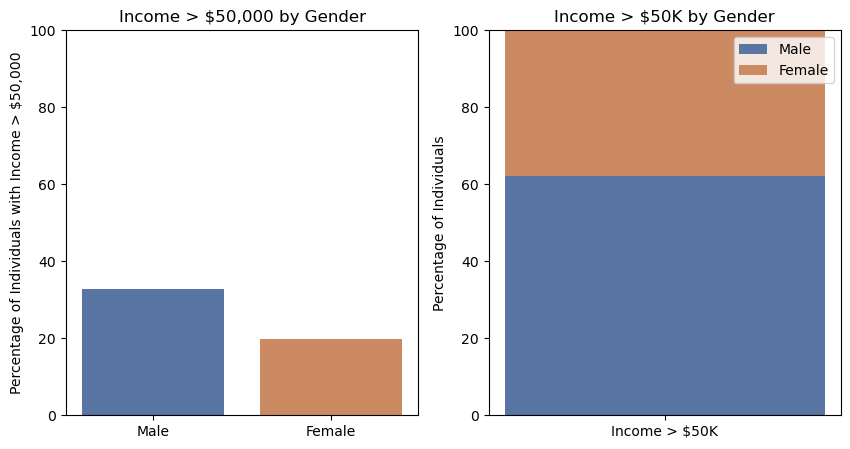

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].bar(["Male", "Female"], [male_percent, female_percent], color=["#5975a4", "#cc8a63"])
axs[0].set_ylim(0, 100)
axs[0].set_ylabel("Percentage of Individuals with Income > $50,000")
axs[0].set_title("Income > $50,000 by Gender")

axs[1].bar("Income > $50K", income_percent[1], width=0.1, color="#5975a4")
axs[1].bar("Income > $50K", income_percent[2], bottom=income_percent[1], width=0.1, color="#cc8a63")
axs[1].set_ylim(0, 100)
axs[1].set_ylabel("Percentage of Individuals")
axs[1].set_title("Income > $50K by Gender")
axs[1].legend(["Male", "Female"])
plt.show()


Now, let's observe the relation of race and sex with income:

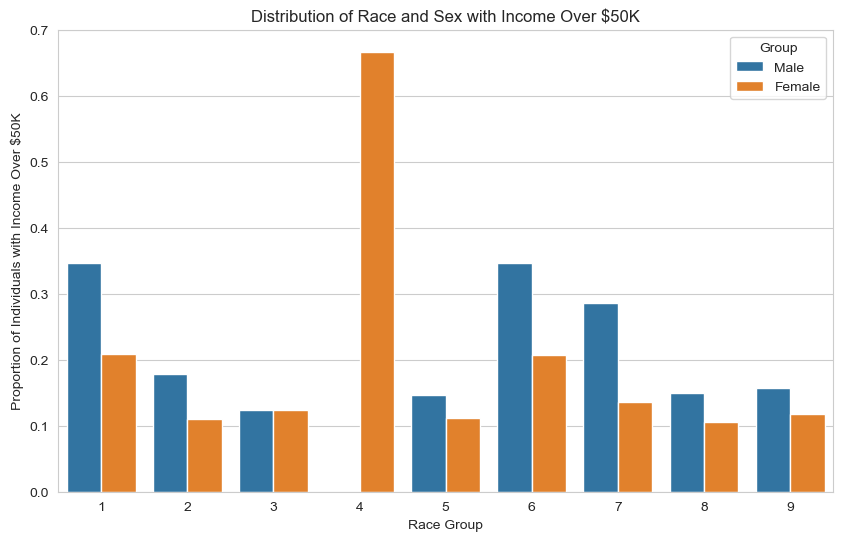

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Computing proportion of positive labels by race and sex
race_proportion = df.groupby(["RAC1P", "group"], as_index=False)["label"].mean()

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=race_proportion, x="RAC1P", y="label", hue="group")

plt.title("Distribution of Race and Sex with Income Over $50K")
plt.xlabel("Race Group")
plt.ylabel("Proportion of Individuals with Income Over $50K")
handles, labels = ax.get_legend_handles_labels()
labels[0] = "Male"
labels[1] = "Female"
ax.legend(handles, labels, title="Group")
plt.show()


THe plot shows that for most race groups, there are more male populations with an income greater than 50k. The only exception to this is race group 4 which is "Alaska Native alone". Further more we can also observe that Asian alone is the race with the highest proportion of individuals with an income greater than 50k collectively between both the genders.

Let's also obeserve the relationship between nativity and Income.

In [11]:

# Computing proportion of positive labels by race and sex
cit_proportion = df.groupby(["CIT", "group"], as_index=False)["label"].mean()


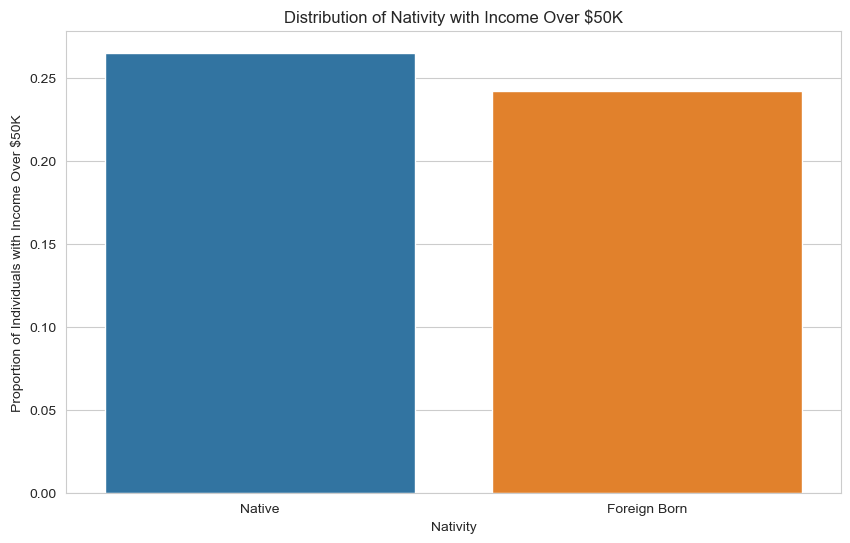

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Computing proportion of positive labels by citizenship
cit_proportion = df.groupby(["NATIVITY"], as_index=False)["label"].mean()


sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=cit_proportion, x="NATIVITY", y="label")

plt.title("Distribution of Nativity with Income Over $50K")
plt.xlabel("Nativity")
plt.ylabel("Proportion of Individuals with Income Over $50K")
plt.gca().set_xticklabels(["Native", "Foreign Born"])
plt.show()


As shown by the bar chart, the poportion of individuals with an income over 50k for Native Born are higher than Foreign Born in Colorado.

# Implementing a Model
For our training data set, we will be using a decision tree model. It utilizes the Scikit-learn library to import the necessary modules, including SVC, LogisticRegression, make_pipeline, StandardScaler, confusion_matrix, cross_val_score, and DecisionTreeClassifier. The code also shows the process tuning a model and cross-validation for a decision tree classifier. It iterates over a range of depth values from 2 to 19. Inside the loop, a pipeline is created using make_pipeline, which includes StandardScaler for data preprocessing and DecisionTreeClassifier with the  depth value. Cross-validation scores are calculated using cross_val_score with cross-validation of 10 folds. Finally, best depth is the depth value equating to the highest score.

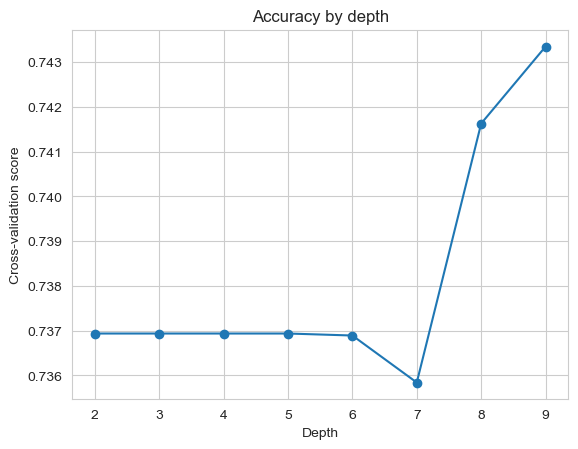

The best depth is 9 with a CV score of 0.7433510512632892


In [13]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

scores = []
depths = range(2, 10)

for depth in depths:
    pipeline = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=depth))
    score = cross_val_score(pipeline, X_train, y_train, cv=10)
    scores.append(score.mean())

best_depth = depths[np.argmax(scores)]

plt.plot(depths, scores, '-o')
plt.xlabel('Depth')
plt.ylabel('Cross-validation score')
plt.title('Accuracy by depth')
plt.show()

print(f"The best depth is {best_depth} with a CV score of {max(scores)}")

In [41]:
model = make_pipeline(StandardScaler(),DecisionTreeClassifier(max_depth=9))
model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=9))])

After building the model, we can check the accuracy scores:

In [42]:
y_hat=model.predict(X_test)

overall_accuracy = model.score(X_test, y_test)

print(f"The overall accuracy of our model is: {overall_accuracy}")


The overall accuracy of our model is: 0.7411943500804578


In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()

post_predictive = tp / (tp+fp)
print(f"PPV: {post_predictive}" )

# calculating fnr and fpr
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)

print(f"False Negative Rate (FNR): {fnr}")
print(f"False Positive Rate (FPR): {fpr}")


PPV: 0.5055118110236221
False Negative Rate (FNR): 0.6697530864197531
False Positive Rate (FPR): 0.11390568319226119


The PPV value indicates the reliability of positive predictions made by our model.This value means that when our model predicts an instance to belong to the positive class, it is correct about 50% times. This suggests that our model has high rate of false positives compared to true positives which means the model is struggling to accurately predict the positive class.

The false negative rate of about 67% indicates that our model failed to recognize 60% of actual positive instances, and thus categorized them as negative. Also, 11.3% of actual negative instances were incorrectly classified as positive by our model as indicated by the falce positicve score.

In [44]:
# Calculating accuracy for male
male_indices = group_test == 1
male_indices = np.squeeze(male_indices)

male_y_test = y_test[male_indices]
male_y_hat = y_hat[male_indices]

male_accuracy = np.mean(male_y_hat == male_y_test)

male_tn, male_fp, male_fn, male_tp = confusion_matrix(male_y_test, male_y_hat).ravel()
male_fnr = male_fn / (male_fn + male_tp)
male_fpr = male_fp / (male_fp + male_tn)

print(f"The accuracy score for males is {male_accuracy}")
print(f"The False Negative Rate (FNR) for males is{male_fnr}")
print(f"The False Positive Rate (FPR) for males is {male_fpr}\n")

# Calculating accuracy female 
female_indices = group_test == 2
female_indices = np.squeeze(female_indices)

female_y_test = y_test[female_indices]
female_y_hat = y_hat[female_indices]

female_accuracy = np.mean(female_y_hat == female_y_test)

female_tn, female_fp, female_fn, female_tp = confusion_matrix(female_y_test, female_y_hat).ravel()
female_fnr = female_fn / (female_fn + female_tp)
female_fpr = female_fp / (female_fp + female_tn)

print(f"The accuracy for females is {female_accuracy}")
print(f"The False Negative Rate (FNR) for females is {female_fnr}")
print(f"The False Positive Rate (FPR) for females is {female_fpr}\n")


The accuracy score for males is 0.7074805288896939
The False Negative Rate (FNR) for males is0.6748099891422367
The False Positive Rate (FPR) for males is 0.1011144332699103

The accuracy for females is 0.7740511915269197
The False Negative Rate (FNR) for females is 0.6610800744878957
The False Positive Rate (FPR) for females is 0.12415595730777608



Although the model performs relatively well for both subgroups, there is a slight difference in accuracy, with females having a slightly higher accuracy compared to males. We will thus examine if our model is accurately calibrated.

In [45]:

male_indices = np.where(group_test == 1)[0]
male_y_hat = y_hat[male_indices]
male_y_test = y_test[male_indices]


female_indices = np.where(group_test == 2)[0]
female_y_hat = y_hat[female_indices]
female_y_test = y_test[female_indices]

matrix_male = confusion_matrix(male_y_test, male_y_hat)
calibration_male = matrix_male[0, 0] / matrix_male[0].sum()
matrix_female = confusion_matrix(female_y_test, female_y_hat)
calibration_female = matrix_female[0, 0] / matrix_female[0].sum()

print(f"correctly predicted positive instances for men:  {calibration_male}")
print(f"correctly predicted positive instances for female:  {calibration_female}")


correctly predicted positive instances for men:  0.8988855667300897
correctly predicted positive instances for female:  0.8758440426922239


The process of Calibration involves checking if the predicted probabilities align with the predicted outcomes. For males, the proportion of correctly predicted positive instances (income greater than $50k) was approximately 0.879. Similarly, for women, the proportion of correctly predicted positive instances was approximately 0.843. Thus, the model appears to be relatively well calibrated for both males and females. In terms of the error rate balance, the fpr for men and fpr for women only has a difference of about 0.03 and about the same for fnr. Hence, the model does not show any significant imbalances in the error rates.

Human Resources Departments in companies in Colorado could make a good use of our model to support salary adjustments across different genders. If the model was to show significant biases, it could lead to unfair treatment or discrimination against certain demographic groups. However in case of male and female in our model, there wasn't a significant bias, hence the impact of deploying your model for large-scale prediction might not cause problems. However, the accuracy scores for male indicates than the model with get it's predictions wrong for about 29 out of every 100 males and 24 out of every 100 females. These scores will have to be improved, if the model were to be used in any significant industry or decision making process.

It is important to consider bias across other features as well and also to consider bias amongst other genders that are not male and female. Hence, I would believe, a lot more experiments are needed to be carried out before implementing this model in any large-scale prediction. Based on my bias audit, the model is not showing any significant problematic bias but as I mentioned earlie,r considering other features and expanding the dataset is essential in using the model for any significant predictions.
